# Data

http://www.inf.ufpr.br/vri/databases/BreaKHis_v1.tar.gz

Setup 

    1. decompress the file mkfold.tag.gz
    2. copy the file BreakHis_v1.tar.gz into the mkfold directory
    3. decompress the BreakHis_v1.tar.gz file
    4. run the script <python mkfold.py>

Models

https://github.com/titu1994/DenseNet/blob/master/densenet.py

https://github.com/snf/keras-fractalnet/blob/master/src/fractalnet.py

https://github.com/DT42/squeezenet_demo/blob/master/model.py

* 82 patients 
* Images taken at different magnifying factors (40X, 100X, 200X, and 400X)
* 2,480  benign and 5,429 malignant samples 
* 700X460 pixels, 3-channel RGB, 8-bit depth in each channel, PNG format
* Samples collected by SOB method, also named partial mastectomy or excisional biopsy (bigger than needle samples)

### Classes
#### Benign Tumors

* **Adenosis (A)**-  breast lobules (milk-producing glands) are enlarged
* **Fibroadenoma (F)**- common benign (non-cancer) tumors made up of both glandular breast tissue and stromal(connective) tissue. 
* **Phyllodes tumor (PT)** -  rare breast tumors that start in the connective (stromal) tissue of the breast. About 1 out of 10 of these tumors are malignant
* **Tubular adenona (TA)**-  ???

#### Malignant Tumors

* **Carcinoma (DC)** - Cancer beginning in the milk ducts. About 80% of all breast cancers are invasive ductal carcinomas.
* **Lobular carcinoma (LC)** - Cancer began in the milk-producing lobules. About 10% of all invasive breast cancers. 
* **Mucinous carcinoma (MC)** - Rare form of invasive ductal carcinoma, where the tumor is made up of abnormal cells that “float” in pools of mucin, a key ingredient in the slimy, slippery substance known as mucus.
* **Papillary carcinoma (PC)** - 1-2% of invasive breast cancers. Well-defined border and is made up of small, finger-like projections. In most cases of invasive papillary carcinoma, ductal carcinoma in situ (DCIS)
(cancer.org, breastcancer.org)

# Imports

In [7]:
import os
import sys
import glob
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
from matplotlib.pyplot import imshow
from PIL import Image
from shutil import copyfile
import scipy.ndimage
from IPython.display import display, HTML
from sklearn.metrics import accuracy_score

from keras.preprocessing import image
from keras.applications.resnet50 import preprocess_input, decode_predictions
from keras.applications.inception_v3 import InceptionV3
from keras.applications.resnet50 import ResNet50
from keras.applications.inception_resnet_v2 import InceptionResNetV2
from keras.applications.densenet import DenseNet121
from keras.models import Model

% matplotlib inline

# Import modules every time you run code imported using %aimport
%load_ext autoreload
%autoreload 1

# Add the src directory for functions
src_dir = os.path.join(os.path.dirname(os.path.dirname(os.getcwd())), 'src')
print(src_dir)
sys.path.append(src_dir)

# import my functions:
%aimport models
from models import*
%aimport functions
from functions import*


# Base Directory where data is stored
base_data_dir = "C:\\Users\\zvil\\Documents\\My Tasks\\New folder (3)\\anomoly\\"
base_out_dir = "C:\\Users\\zvil\\Documents\\My Tasks\\New folder (3)\\anomoly\\BreaKHis_out"

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
C:\Users\zvil\Documents\My Tasks\New folder (3)\anomoly\zvi-lapp-anomaly-detection-breakhis\breakHis\src


# Make Data:  5-Fold CV
* mkfold directory contains the 5 folds extracted from https://web.inf.ufpr.br/vri/databases/breast-cancer-histopathological-database-breakhis/ , using their code to create the 5-folds/

We will:
* Create a validation folder which is 20% of the train set
* Not sure if best to seperate patients between validation and training set. Data leakage if not seperated, but if it is there will be missing classes in validation. 
* We go with seperate. Hopefully color of slides isn't a problem between patients. 
* Also stratify by tumor class to keep examples in the validation set.

To stratify the samples for a given fold and magnification:
1. For each tumor class find the unique IDs
2. Take 20% of these IDs as validation, the rest as training. 
3. Copy all of each ID's images into the correct folder.
4. Assume only one class for each ID

In [22]:
in_loc = os.path.join(base_data_dir, 'mkfold')
out_loc = os.path.join(base_data_dir, 'mkfold_keras_8')
all_files = glob.glob(in_loc+'/**/*.png', recursive=True)
valid_proportion = .8

print(str(len(all_files)))

# check os windows or linux based to rsplit correctly
for file in all_files:
    name = file.rsplit('\\', 1)[1]
    fold = file.rsplit('mkfold\\', 1)[1].split('\\', 1)[0]
    ttv_dir = file.rsplit('mkfold\\', 1)[1].split('\\', 1)[1].split('\\', 1)[0]
    zoom = file.rsplit('\\', 1)[1].rsplit('-', 1)[0].rsplit('-', 1)[1]
    tumor_class = file.rsplit('\\', 1)[1].split('_', 1)[1].split('-', 1)[0]
    new_folder = os.path.join(out_loc, fold, zoom, ttv_dir, tumor_class)
    if not os.path.exists(new_folder):
        os.makedirs(new_folder)
    copyfile(file, os.path.join(new_folder, name))


# Now for each fold, and at each magnification, add a validation folder and take 20% of the train set for it
for fold in ['fold1', 'fold2', 'fold3', 'fold4', 'fold5']:
    for mag in ['40', '100', '200', '400']:
        train_loc = os.path.join(out_loc, fold, mag, 'train')
        valid_loc = os.path.join(out_loc, fold, mag, 'valid')
        if not os.path.exists(valid_loc):
            os.makedirs(valid_loc)
        all_train = glob.glob(train_loc+'/**/*.png', recursive=True)

        # Get all the patients:
        all_ids = [loc.rsplit('\\', 1)[1].split('-', 3)[2] for loc in all_train]
        all_ids = list(set(all_ids))
        print('Number of Patients in ', fold, ' magnification ', mag,  ' : ',  len(all_ids))

        # Get all the tumor classes, and stratify the patients so test and valid sets contain at least one from each type
        tumor_class_list = list(set([loc.rsplit('\\', 1)[1].split('_', 1)[1].split('-', 1)[0] for loc in all_train]))

        for tumor_class in tumor_class_list:
            new_folder = os.path.join(valid_loc, tumor_class)
            if not os.path.exists(new_folder):
                os.makedirs(new_folder)

            # for each tumor class find all the patients, and split the patients into train and valid
            class_ids = [loc.rsplit('\\', 1)[1].split('-', 3)[2] for loc in all_train if loc.rsplit('\\', 1)[1].split('_', 1)[1].split('-', 1)[0] == tumor_class]
            random.shuffle(class_ids)
            class_ids = list(set(class_ids))

            valid_ids = class_ids[int(np.floor(len(class_ids)*valid_proportion)):]
            # add only if both the id is correct, and if the type is correct. (some patients have 2 types)
            valid_files = [loc for loc in all_train if loc.rsplit('\\', 1)[1].split('-', 3)[2] in valid_ids and loc.rsplit('\\', 1)[1].split('_', 1)[1].split('-', 1)[0] == tumor_class]

            # copy the validation files into the new directory, and delete them from the training 
            for file in valid_files:
                name = file.rsplit('\\', 1)[1]
                copyfile(file, os.path.join(new_folder, name))
                os.remove(file)
            #print('Number of patients of type ',  tumor_class, ' is: ', num_ids, ' Valid: ', len(valid_files))

39545
Number of Patients in  fold1  magnification  40  :  54
Number of Patients in  fold1  magnification  100  :  54
Number of Patients in  fold1  magnification  200  :  54
Number of Patients in  fold1  magnification  400  :  54
Number of Patients in  fold2  magnification  40  :  53
Number of Patients in  fold2  magnification  100  :  53
Number of Patients in  fold2  magnification  200  :  53
Number of Patients in  fold2  magnification  400  :  53
Number of Patients in  fold3  magnification  40  :  54
Number of Patients in  fold3  magnification  100  :  54
Number of Patients in  fold3  magnification  200  :  54
Number of Patients in  fold3  magnification  400  :  54
Number of Patients in  fold4  magnification  40  :  53
Number of Patients in  fold4  magnification  100  :  53
Number of Patients in  fold4  magnification  200  :  53
Number of Patients in  fold4  magnification  400  :  53
Number of Patients in  fold5  magnification  40  :  54
Number of Patients in  fold5  magnification  10

## Look at a few images:

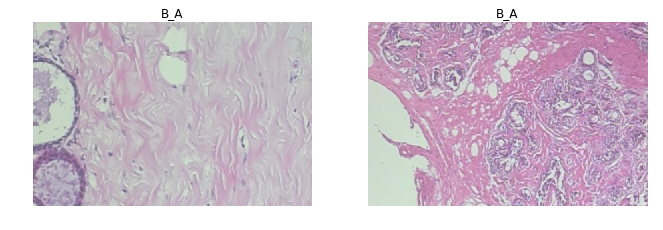

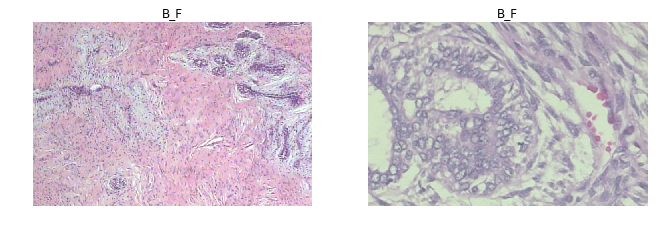

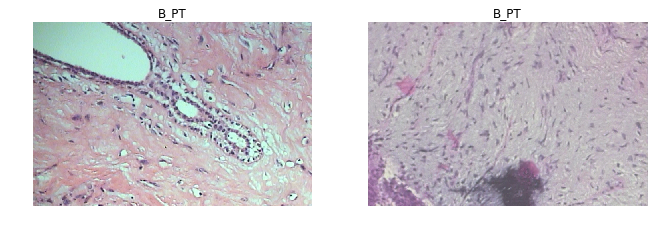

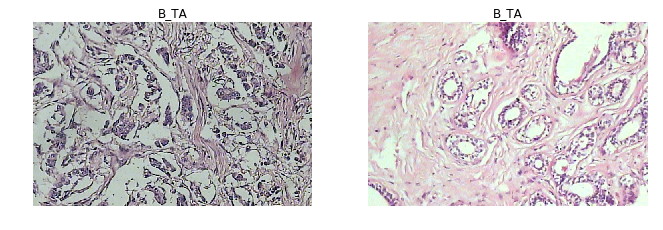

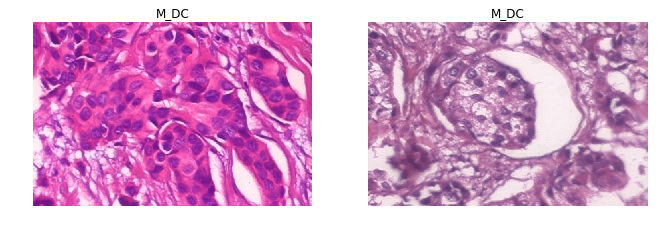

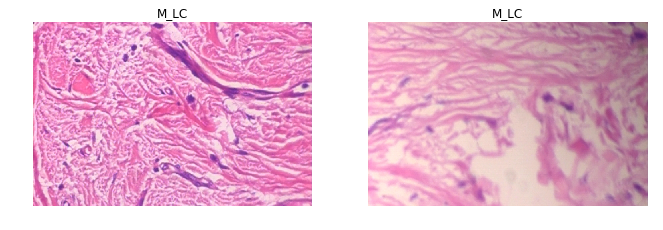

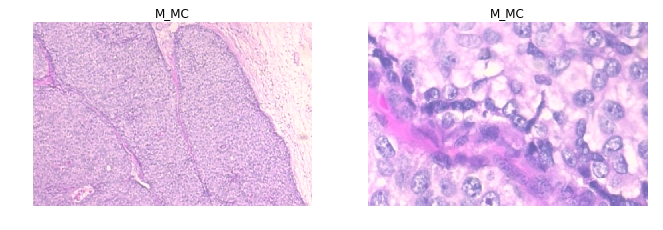

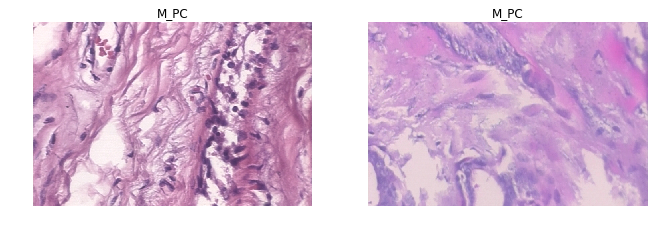

In [26]:
# Look at a few examples:
loc = "C:\\Users\\zvil\\Documents\\My Tasks\\New folder (3)\\anomoly\\mkfold_keras_8"
all_image_locs = glob.glob(loc +'/**/*.png', recursive=True)

classes = ['B_A', 'B_F', 'B_PT', 'B_TA', 'M_DC', 'M_LC', 'M_MC', 'M_PC']

for slide_class in classes:
    image_locs = [loc for loc in all_image_locs if loc.rsplit('\\', 1)[1].split('_', 1)[1].split('-', 1)[0] == slide_class]
    image_locs = np.random.choice(image_locs, 2)

    f = plt.figure(figsize=(11,8))
    for i in range(len(image_locs)):
        sp = f.add_subplot(2, len(image_locs)//1, i+1)
        sp.axis('Off')
        sp.set_title(image_locs[i].rsplit('\\', 1)[-1], fontsize=10)
        image = np.asarray(Image.open(image_locs[i]))
        plt.title(slide_class)

        #plt.tight_layout()
        plt.imshow(image)

In [28]:
train_loc = "C:\\Users\\zvil\\Documents\\My Tasks\\New folder (3)\\anomoly\\mkfold_keras_8"
all_train = glob.glob(train_loc+'/**/*.png', recursive=True)

all_ids = [loc.rsplit('\\', 1)[1].split('-', 3)[2] for loc in all_train]
all_ids = list(set(all_ids))

for ID in all_ids:
    files = [loc for loc in all_train if loc.rsplit('\\', 1)[1].split('-', 3)[2] in ID]
    class_ids = [loc.rsplit('\\', 1)[1].split('_', 1)[1].split('-', 1)[0] for loc in files]
    if len(list(set(class_ids)))>1:
        print('Patient ID: ', ID, 'classes: ', list(set(class_ids)))

Patient ID:  12773 classes:  ['M_MC', 'M_DC']
Patient ID:  13412 classes:  ['M_LC', 'M_DC']


In [8]:
# ResNet50 = ResNet50(weights='imagenet', include_top=False)
# ResNet50.save("C:\\Users\\zvil\\Documents\\My Tasks\\New folder (3)\\anomoly\\zvi-lapp-anomaly-detection-breakhis\\breakHis\\src\\imagenet_models\\resnet50")

# InceptionResNetV2 = InceptionResNetV2(weights='imagenet', include_top=False)
# InceptionResNetV2.save("C:\\Users\\zvil\\Documents\\My Tasks\\New folder (3)\\anomoly\\zvi-lapp-anomaly-detection-breakhis\\breakHis\src\\imagenet_models\\inceptionresnetv2")

# DenseNet121 =  DenseNet121(weights='imagenet', include_top=False)
# DenseNet121.save("C:\\Users\\zvil\\Documents\\My Tasks\\New folder (3)\\anomoly\\zvi-lapp-anomaly-detection-breakhis\\breakHis\src\\imagenet_models\\densenet121")


# InceptionV3 = InceptionV3(weights='imagenet', include_top=False)# Incep 
# InceptionV3.save("C:\\Users\\zvil\\Documents\\My Tasks\\New folder (3)\\anomoly\\zvi-lapp-anomaly-detection-breakhis\\breakHis\src\\imagenet_models\\inceptionv3")

# ResNet50

C:\ProgramData\Anaconda3\envs\tensorflow\lib\site-packages\keras\engine\saving.py:270: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


num_train 951
num_valid 370
steps_per_epoch 59.0
validation_steps 23.0
Found 951 images belonging to 8 classes.
Found 370 images belonging to 8 classes.
Training the top layers only
Epoch 1/5
59/59 [==============================] - 3742s 63s/step - loss: 1.2277 - acc: 0.5910 - val_loss: 3.7819 - val_acc: 0.1196
Epoch 2/5
59/59 [==============================] - 3618s 61s/step - loss: 0.7131 - acc: 0.7600 - val_loss: 4.5914 - val_acc: 0.1522
Epoch 3/5
59/59 [==============================] - 3611s 61s/step - loss: 0.5848 - acc: 0.7950 - val_loss: 4.8466 - val_acc: 0.2201
Epoch 4/5
59/59 [==============================] - 3732s 63s/step - loss: 0.4827 - acc: 0.8453 - val_loss: 5.3911 - val_acc: 0.1576
Epoch 5/5
59/59 [==============================] - 3654s 62s/step - loss: 0.4203 - acc: 0.8567 - val_loss: 4.9736 - val_acc: 0.2935
Make sure nothing is going terribly wrong with training last layers
Final 2 Epochs Avg Validation loss:  0.22554347826086957


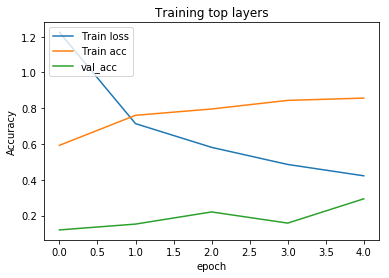

<Figure size 720x432 with 0 Axes>

Fine tuning layers
Epoch 1/100
59/59 [==============================] - 3637s 62s/step - loss: 0.4532 - acc: 0.8344 - val_loss: 4.9736 - val_acc: 0.2935

Epoch 00001: val_loss improved from inf to 4.97355, saving model to C:\Users\zvil\Documents\My Tasks\New folder (3)\anomoly\BreaKHis_out\resnet50\fine_tune_.01-0.29.hdf5
Epoch 2/100
59/59 [==============================] - 3621s 61s/step - loss: 0.4234 - acc: 0.8525 - val_loss: 4.9736 - val_acc: 0.2935

Epoch 00002: val_loss did not improve from 4.97355
Epoch 3/100
59/59 [==============================] - 3596s 61s/step - loss: 0.4202 - acc: 0.8424 - val_loss: 4.9736 - val_acc: 0.2935

Epoch 00003: val_loss did not improve from 4.97355
Epoch 4/100
59/59 [==============================] - 3594s 61s/step - loss: 0.4361 - acc: 0.8517 - val_loss: 4.9736 - val_acc: 0.2935

Epoch 00004: val_loss did not improve from 4.97355
Epoch 5/100
59/59 [==============================] - 3596s 61s/step - loss: 0.4246 - acc: 0.8461 - val_loss: 4.9736 - 

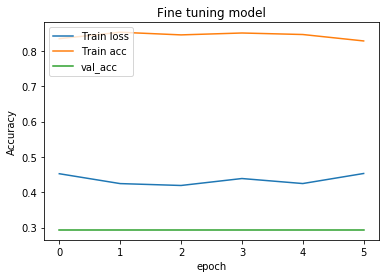

<Figure size 720x432 with 0 Axes>

In [2]:
base_model = load_model("C:\\Users\\zvil\\Documents\\My Tasks\\New folder (3)\\anomoly\\resnet50")
data_loc = os.path.join(base_data_dir, 'mkfold_keras_8', 'fold1')
out_loc = os.path.join(base_out_dir, 'resnet50')
num_out = 8
magnification = 100

ft_pre_model(base_model, data_loc, out_loc, magnification, num_out, epochs_first=5, 
                          img_dim=512, layer_train=249, epochs=100)

# InceptionResNetV2

C:\ProgramData\Anaconda3\envs\tensorflow\lib\site-packages\keras\engine\saving.py:270: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


num_train 951
num_valid 370
steps_per_epoch 59.0
validation_steps 23.0
Found 951 images belonging to 8 classes.
Found 370 images belonging to 8 classes.
Training the top layers only
Epoch 1/5
59/59 [==============================] - 3229s 55s/step - loss: 1.6280 - acc: 0.4776 - val_loss: 9.6358 - val_acc: 0.4022
Epoch 2/5
59/59 [==============================] - 3217s 55s/step - loss: 1.4739 - acc: 0.5067 - val_loss: 9.6358 - val_acc: 0.4022
Epoch 3/5
59/59 [==============================] - 3215s 54s/step - loss: 1.3666 - acc: 0.5232 - val_loss: 9.6358 - val_acc: 0.4022
Epoch 4/5
59/59 [==============================] - 3219s 55s/step - loss: 1.2392 - acc: 0.5740 - val_loss: 9.6358 - val_acc: 0.4022
Epoch 5/5
59/59 [==============================] - 3240s 55s/step - loss: 1.1659 - acc: 0.5869 - val_loss: 9.6358 - val_acc: 0.4022
Make sure nothing is going terribly wrong with training last layers
Final 2 Epochs Avg Validation loss:  0.40217391304347827


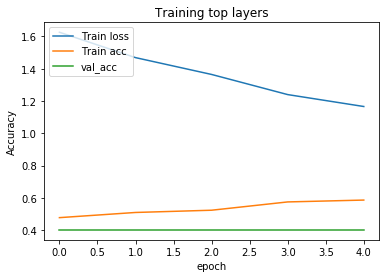

<Figure size 720x432 with 0 Axes>

Fine tuning layers
Epoch 1/100
59/59 [==============================] - 5681s 96s/step - loss: 1.0714 - acc: 0.6403 - val_loss: 9.6358 - val_acc: 0.4022

Epoch 00001: val_loss improved from inf to 9.63582, saving model to C:\Users\zvil\Documents\My Tasks\New folder (3)\anomoly\BreaKHis_out\inceptionresnetv2\fine_tune_.01-0.40.hdf5
Epoch 2/100
59/59 [==============================] - 5632s 95s/step - loss: 1.0398 - acc: 0.6437 - val_loss: 9.6358 - val_acc: 0.4022

Epoch 00002: val_loss did not improve from 9.63582
Epoch 3/100
59/59 [==============================] - 5631s 95s/step - loss: 0.9979 - acc: 0.6519 - val_loss: 9.4272 - val_acc: 0.4022

Epoch 00003: val_loss improved from 9.63582 to 9.42721, saving model to C:\Users\zvil\Documents\My Tasks\New folder (3)\anomoly\BreaKHis_out\inceptionresnetv2\fine_tune_.03-0.40.hdf5
Epoch 4/100
59/59 [==============================] - 5622s 95s/step - loss: 0.9513 - acc: 0.6932 - val_loss: 8.1609 - val_acc: 0.3886

Epoch 00004: val_loss improv

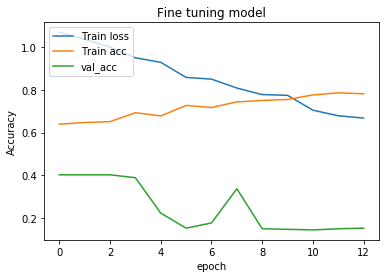

<Figure size 720x432 with 0 Axes>

In [3]:
base_model = load_model("C:\\Users\\zvil\\Documents\\My Tasks\\New folder (3)\\anomoly\\inceptionresnetv2")
data_loc = os.path.join(base_data_dir, 'mkfold_keras_8', 'fold1')
out_loc = os.path.join(base_out_dir, 'inceptionresnetv2')
num_out = 8
magnification = 100

ft_pre_model(base_model, data_loc, out_loc, magnification, num_out, epochs_first=5, 
                          img_dim=512, layer_train=249, epochs=100)

In [10]:
# continueing on second fold
base_model = load_model(base_out_dir+"\\inceptionresnetv2")
data_loc = os.path.join(base_data_dir, 'mkfold_keras_8', 'fold2')
out_loc = os.path.join(base_out_dir, 'inceptionresnetv2')
num_out = 8
magnification = 100

ft_pre_model(base_model, data_loc, out_loc, magnification, num_out, epochs_first=5, 
                          img_dim=512, layer_train=249, epochs=100)

OSError: Unable to open file (unable to open file: name = 'C:\Users\zvil\Documents\My Tasks\New folder (3)\anomoly\BreaKHis_out\inceptionresnetv2', errno = 13, error message = 'Permission denied', flags = 0, o_flags = 0)

# Densenet

C:\ProgramData\Anaconda3\envs\tensorflow\lib\site-packages\keras\engine\saving.py:270: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


num_train 951
num_valid 370
steps_per_epoch 59.0
validation_steps 23.0
Found 951 images belonging to 8 classes.
Found 370 images belonging to 8 classes.
Training the top layers only
Epoch 1/5
59/59 [==============================] - 5173s 88s/step - loss: 1.3457 - acc: 0.5412 - val_loss: 6.5296 - val_acc: 0.0842
Epoch 2/5
59/59 [==============================] - 5165s 88s/step - loss: 0.9283 - acc: 0.6800 - val_loss: 7.7119 - val_acc: 0.0707
Epoch 3/5
59/59 [==============================] - 5166s 88s/step - loss: 0.7530 - acc: 0.7272 - val_loss: 8.0987 - val_acc: 0.0788
Epoch 4/5
59/59 [==============================] - 5199s 88s/step - loss: 0.6300 - acc: 0.7738 - val_loss: 8.7215 - val_acc: 0.0788
Epoch 5/5
59/59 [==============================] - 5169s 88s/step - loss: 0.5570 - acc: 0.8231 - val_loss: 8.6861 - val_acc: 0.0842
Make sure nothing is going terribly wrong with training last layers
Final 2 Epochs Avg Validation loss:  0.08152173913043478


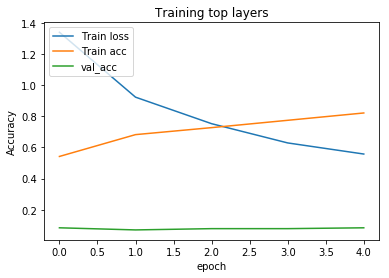

<Figure size 720x432 with 0 Axes>

Fine tuning layers
Epoch 1/100
59/59 [==============================] - 6151s 104s/step - loss: 0.4776 - acc: 0.8546 - val_loss: 9.8303 - val_acc: 0.0788

Epoch 00001: val_loss improved from inf to 9.83030, saving model to C:\Users\zvil\Documents\My Tasks\New folder (3)\anomoly\BreaKHis_out\densenet\fine_tune_.01-0.08.hdf5
Epoch 2/100
59/59 [==============================] - 6140s 104s/step - loss: 0.4823 - acc: 0.8479 - val_loss: 9.8515 - val_acc: 0.0788

Epoch 00002: val_loss did not improve from 9.83030
Epoch 3/100
59/59 [==============================] - 6268s 106s/step - loss: 0.4507 - acc: 0.8617 - val_loss: 9.9846 - val_acc: 0.0788

Epoch 00003: val_loss did not improve from 9.83030
Epoch 4/100
59/59 [==============================] - 6355s 108s/step - loss: 0.3991 - acc: 0.8729 - val_loss: 10.0447 - val_acc: 0.0788

Epoch 00004: val_loss did not improve from 9.83030
Epoch 5/100
59/59 [==============================] - 6160s 104s/step - loss: 0.3797 - acc: 0.8757 - val_loss: 10.

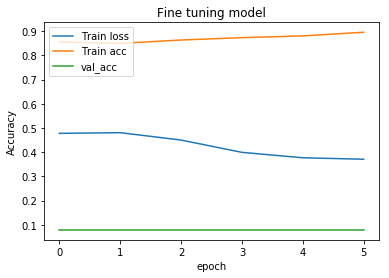

<Figure size 720x432 with 0 Axes>

In [4]:
base_model = load_model("C:\\Users\\zvil\\Documents\\My Tasks\\New folder (3)\\anomoly\\zvi-lapp-anomaly-detection-breakhis\\breakHis\src\\imagenet_models\\densenet121")
data_loc = os.path.join(base_data_dir, 'mkfold_keras_8', 'fold1')
out_loc = os.path.join(base_out_dir, 'densenet')
num_out = 8
magnification = 100

ft_pre_model(base_model, data_loc, out_loc, magnification, num_out, epochs_first=5, 
                          img_dim=512, layer_train=249, epochs=100)

# InceptionNet

C:\ProgramData\Anaconda3\envs\tensorflow\lib\site-packages\keras\engine\saving.py:270: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


num_train 951
num_valid 370
steps_per_epoch 59.0
validation_steps 23.0
Found 951 images belonging to 8 classes.
Found 370 images belonging to 8 classes.
Training the top layers only
Epoch 1/5
59/59 [==============================] - 1871s 32s/step - loss: 1.6532 - acc: 0.4551 - val_loss: 8.8190 - val_acc: 0.2500
Epoch 2/5
59/59 [==============================] - 1849s 31s/step - loss: 1.3965 - acc: 0.5102 - val_loss: 10.0827 - val_acc: 0.1957
Epoch 3/5
59/59 [==============================] - 1845s 31s/step - loss: 1.2923 - acc: 0.5285 - val_loss: 10.9283 - val_acc: 0.1386
Epoch 4/5
59/59 [==============================] - 1846s 31s/step - loss: 1.1892 - acc: 0.5846 - val_loss: 9.5085 - val_acc: 0.3451
Epoch 5/5
59/59 [==============================] - 1845s 31s/step - loss: 1.0775 - acc: 0.6047 - val_loss: 11.1546 - val_acc: 0.2038
Make sure nothing is going terribly wrong with training last layers
Final 2 Epochs Avg Validation loss:  0.27445652173913043


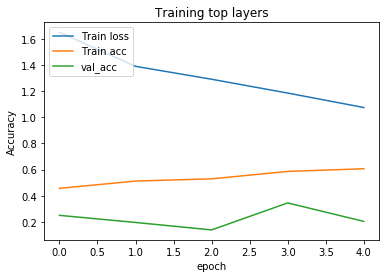

<Figure size 720x432 with 0 Axes>

Fine tuning layers
Epoch 1/100
59/59 [==============================] - 2010s 34s/step - loss: 1.0118 - acc: 0.6435 - val_loss: 11.1346 - val_acc: 0.2446

Epoch 00001: val_loss improved from inf to 11.13457, saving model to C:\Users\zvil\Documents\My Tasks\New folder (3)\anomoly\BreaKHis_out\inceptionv3\fine_tune_.01-0.24.hdf5
Epoch 2/100
59/59 [==============================] - 1991s 34s/step - loss: 0.9308 - acc: 0.6745 - val_loss: 10.9950 - val_acc: 0.2609

Epoch 00002: val_loss improved from 11.13457 to 10.99499, saving model to C:\Users\zvil\Documents\My Tasks\New folder (3)\anomoly\BreaKHis_out\inceptionv3\fine_tune_.02-0.26.hdf5
Epoch 3/100
59/59 [==============================] - 1992s 34s/step - loss: 0.9043 - acc: 0.6991 - val_loss: 11.1992 - val_acc: 0.2500

Epoch 00003: val_loss did not improve from 10.99499
Epoch 4/100
59/59 [==============================] - 1987s 34s/step - loss: 0.8672 - acc: 0.7038 - val_loss: 11.2165 - val_acc: 0.2473

Epoch 00004: val_loss did not im

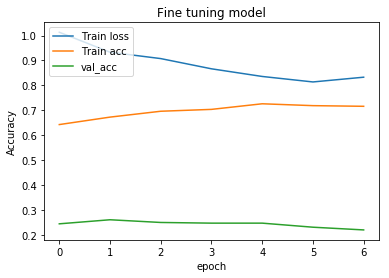

<Figure size 720x432 with 0 Axes>

In [9]:
base_model = load_model("C:\\Users\\zvil\\Documents\\My Tasks\\New folder (3)\\anomoly\\zvi-lapp-anomaly-detection-breakhis\\breakHis\src\\imagenet_models\\inceptionv3")
data_loc = os.path.join(base_data_dir, 'mkfold_keras_8', 'fold1')
out_loc = os.path.join(base_out_dir, 'inceptionv3')
num_out = 8
magnification = 100

ft_pre_model(base_model, data_loc, out_loc, magnification, num_out, epochs_first=5, 
                          img_dim=512, layer_train=249, epochs=100)

# Visualize

In [ ]:
model_loc = os.path.join(base_out_dir, 'inception_pre_249', 'fine_tune_.19-0.75.hdf5')
# model = load_model(model_loc)

# img_loc = '/home/rbbidart/project/rbbidart/breakHis/mkfold_keras_8/fold1/100/valid/B_F/SOB_B_F-14-14134-100-001.png'
img_loc = '/home/rbbidart/project/rbbidart/breakHis/mkfold_keras_8/fold1/100/valid/B_F/SOB_B_F-14-14134-100-021.png'

visualize_incp(model, img_loc)